1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [1]:
import numpy as np
import pandas as pd
from scipy import stats


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

'%.4f'

In [2]:
tau = 3052

def p(t, tau):
    return 1-2**(-t/tau)

x = np.arange(10000)
prob_disp = p(x,tau)
# plt.plot(prob_disp)


In [3]:
record_decayed = []
tallium = pd.DataFrame(np.random.uniform(size=(1000,1)))
for t in range(10000):
    prob = p(t, tau)
    tallium_len = len(tallium)
    tallium[tallium.iloc[:,0]<prob] = -1
    #drop decayed rows
    tallium = tallium.drop(tallium[tallium[0] == -1].index)
    # get decayed number by difference of length
    decayed = tallium_len - len(tallium)
    # store decayed number
    record_decayed.append(decayed)

record_lead = np.cumsum(record_decayed)
record_tallium = 1000-record_lead

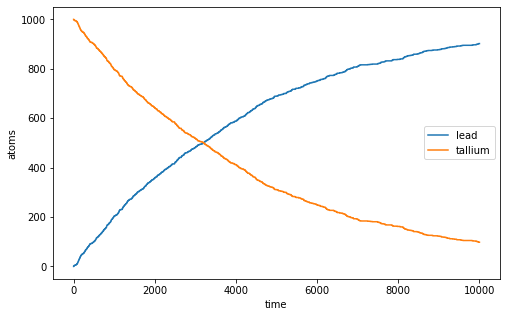

In [4]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(record_lead, label='lead')
ax.plot(record_tallium, label='tallium')
ax.set_xlabel("time")
ax.set_ylabel("atoms")
ax.legend()


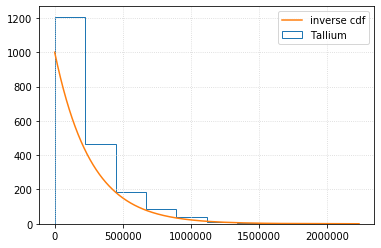

In [12]:
#second part
def p_inv(t, tau):
    return -tau*np.log2(1 - t) 

u = np.random.random(2000)
v = p_inv(u, 3052*60)

plt.hist(v, histtype='step', label='Tallium')
plt.plot(np.sort(p_inv(u, 3052*60)), (1-(np.sort(u)))*1000, label='inverse cdf')
plt.legend()
plt.grid(linestyle=':', color='lightgray')


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [ ]:
E = 7.7 * 1.60218e-13

# bohr radius from Wikipedia
a_0 = 5.29e-11 

# vacuum permittivity from Wikipedia
eps_0 = 8.85e-12 

# std gaussian
sigma = a_0/100

# n of alpha particles
n_a = int(1e6) 

# gold atom
Z = 79 

# electron charge
e = -1.6e-19 

In [34]:
z = np.random.random(n_a)
theta_g = 2*np.pi*np.random.random(n_a)
r = np.sqrt(-2*np.log(z))
x = r*np.cos(theta_g)*sigma
y = r*np.sin(theta_g)*sigma
 
# compute distance from center
b = np.array(np.linalg.norm(np.array(list(zip(x, y))), axis=1)) 

# compute the angle of the particles
theta = 2*np.arctan((Z*e**2)/(2*np.pi*eps_0*E*b)) 

# fraction of particles that "bounce back"
bounce_back = np.sum(theta > np.pi/2)/n_a 

print(f"The fraction of particles that bounce back are: {bounce_back}")

The fraction of particles that bounce back are: 0.00156


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [15]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2
interval = [0,2]
N = 10000

#hit/miss
x = np.random.random(N)*(interval[1]-interval[0])
y = np.random.random(N)
Integral_hm = (interval[1]-interval[0])*np.sum(f(x))/N

#integral with trapz
I = np.trapz(f(x), x)

print(f'integral with hit/miss method {Integral_hm}, error is {np.abs(I-Integral_hm)}')

integral with hit/miss method 1.4588242696056493, error is 3.740315434464493


In [18]:
#mean value method
x = 2*np.random.random(N)
Integral_mv = (interval[1]-interval[0])*np.sum(f(x))/N

print(f'integral with mean value method {Integral_mv}, error is {np.abs(I-Integral_mv)}')
print('The mean value method is slightly more precise than the hit/miss method')

integral with mean value method 1.453543009653022, error is 3.735034174511866
The mean value method is slightly more precise than the hit/miss method


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [32]:
def f(x,y):
    out = np.zeros(np.shape(x))
    out[x**2+y**2 <= 1] = 1
    return out
    
N = 10000000
def I_2d():
    x = np.random.uniform(-1,1,(1,N))
    y = np.random.uniform(-1,1,(1,N))
    return 2**2*np.sum(f(x,y))/N

print(f"two dimensional solution, circle area:{I_2d()}")
    

two dimensional solution, circle area:3.1410676


In [31]:
#generalized smarter solution
def f(x):
    return np.sum(x**2, axis=0) <= 1

def I_g(dim):
    x = np.random.uniform(-1,1, (dim, N))
    return 2**dim*np.sum(f(x))/N

N = 1000000

print(f"Generalized solution, integral 10D sphere:{I_g(10)}")

Generalized solution, integral 10D sphere:2.591744


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [39]:
#evaluated function from integral
def f(x):
    return (x**(-1/2))/(np.exp(x)+1)

def w(x):
    return 1/np.sqrt(x)

N = 100000

# compute I_w with mean value method
x0 = np.random.random(N)
I_w = np.sum(w(x0))/N
x1 = np.random.uniform(0, 1, N)**2
I = (1/N)*np.sum(f(x1)/w(x1))*I_w


#compute integral with hit/miss method
x0 = np.random.random(N)
I_w_hm = np.sum(w(x0) > x0)/N
x1 = np.random.uniform(0, 1, N)**2
I_hm = (1/N)*np.sum(f(x1)/w(x1))*I_w

print(f"Integral mean value method: {I}")
print(f"Integral hit/miss method: {I_hm}")

print('we got similar acceptable values from the two methods')

Integral mean value method: 0.8422440817613618
Integral hit/miss method: 0.8439127209733258
we got similar acceptable values from the two methods
